Cargar datos, limpieza del dataset y importaciones necesarias para el codigo

In [67]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


data_path = "wdbc.data"
names_path = "wdbc.names"

Cargar los datos 

In [68]:

# Lista de las 30 columnas según wdbc.names
feature_names = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

# Asignar encabezados: ID, Diagnosis, 30 features
column_names = ["ID", "Diagnosis"] + feature_names

# Cargar el dataset con nombres correctos
df = pd.read_csv("wdbc.data", header=None, names=column_names)

# Mapear diagnósticos: M = Maligno (1), B = Benigno (0)
df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})

# Mostrar estructura general
print("Dimensiones del dataset:", df.shape)
print("\nDistribución de clases:")
print(df["Diagnosis"].value_counts())

print("\nPrimeras filas:")
display(df.head())

print("\nValores faltantes:")
print(df.isnull().sum().sum())


Dimensiones del dataset: (569, 32)

Distribución de clases:
Diagnosis
0    357
1    212
Name: count, dtype: int64

Primeras filas:


,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Valores faltantes:
0


Seleccion de las caracteristicas y análisis descriptivo

In [69]:
# Calcular la varianza de cada caracteristica

variances = df.drop(columns=["ID", "Diagnosis"]).var().sort_values(ascending=False)
print("Top 10 características con mayor varianza:\n")
print(variances.head(10))

Top 10 características con mayor varianza:

area_worst         324167.385102
area_mean          123843.554318
area_se              2069.431583
perimeter_worst      1129.130847
perimeter_mean        590.440480
texture_worst          37.776483
radius_worst           23.360224
texture_mean           18.498909
radius_mean            12.418920
perimeter_se            4.087896
dtype: float64


In [70]:
# Calcular correlacion con el diagnostico (Maligno o Benigno)

correlations = df.corr(numeric_only=True)["Diagnosis"].sort_values(ascending=False)
print("\nCorrelación de cada característica con el diagnóstico:\n")
print(correlations.head(10))



Correlación de cada característica con el diagnóstico:

Diagnosis               1.000000
concave_points_worst    0.793566
perimeter_worst         0.782914
concave_points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
Name: Diagnosis, dtype: float64


In [71]:
selected_features = ["radius_mean", "texture_mean", "concavity_mean"]

print("\nCaracterísticas seleccionadas para el análisis:", selected_features)


Características seleccionadas para el análisis: ['radius_mean', 'texture_mean', 'concavity_mean']


In [72]:
print("\nResumen estadístico de las variables seleccionadas:")
display(df[selected_features].describe())


Resumen estadístico de las variables seleccionadas:


,radius_mean,texture_mean,concavity_mean
count,569.000000,569.000000,569.000000
mean,14.127292,19.289649,0.088799
std,3.524049,4.301036,0.079720
min,6.981000,9.710000,0.000000
25%,11.700000,16.170000,0.029560
50%,13.370000,18.840000,0.061540
75%,15.780000,21.800000,0.130700
max,28.110000,39.280000,0.426800


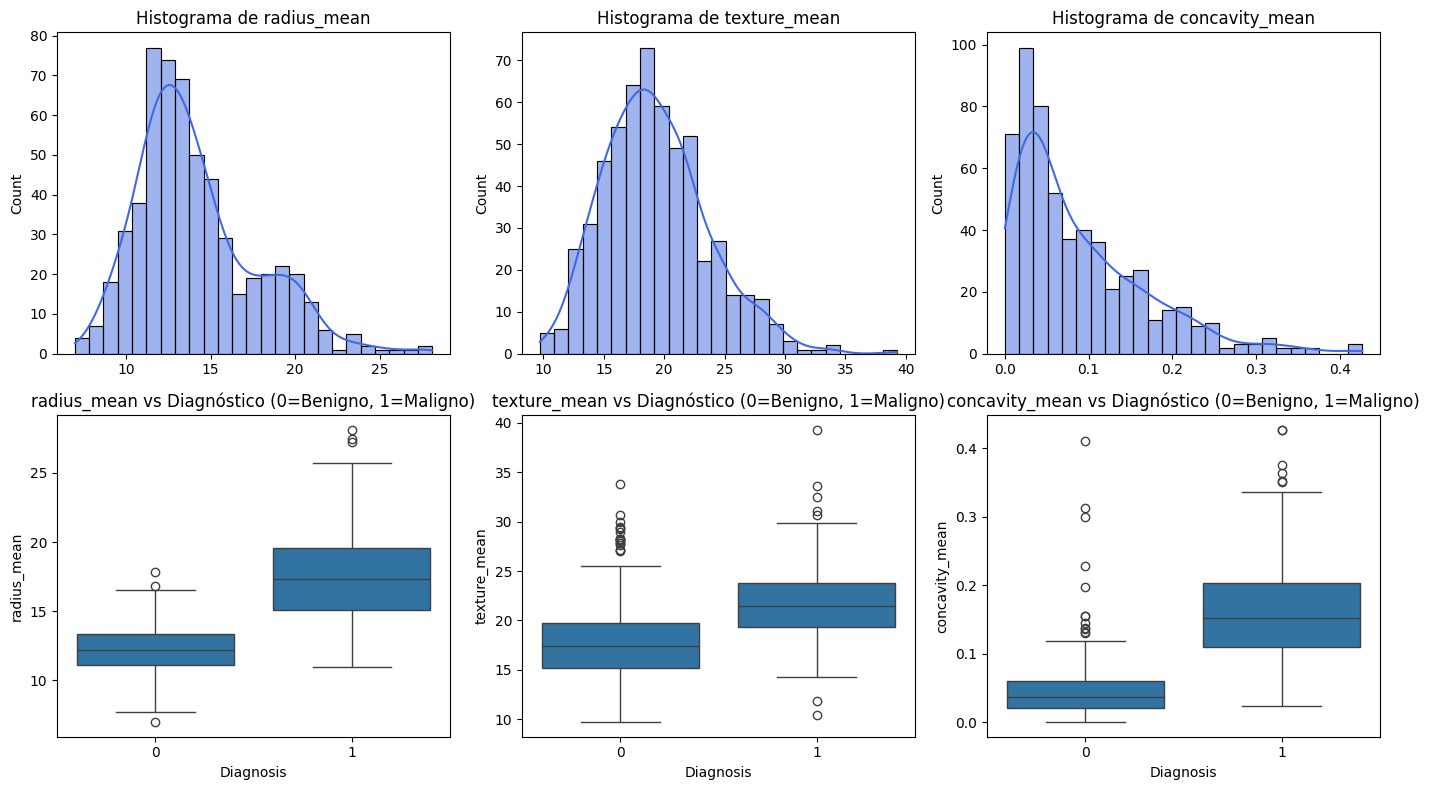

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for i, feature in enumerate(selected_features):
    # Histograma
    sns.histplot(df[feature], bins=25, ax=axes[0, i], kde=True, color='royalblue')
    axes[0, i].set_title(f"Histograma de {feature}")
    axes[0, i].set_xlabel("")
    # Boxplot por clase
    sns.boxplot(x="Diagnosis", y=feature, data=df, ax=axes[1, i])
    axes[1, i].set_title(f"{feature} vs Diagnóstico (0=Benigno, 1=Maligno)")
plt.tight_layout()
plt.savefig("histogramas.png", dpi=300, bbox_inches="tight")
plt.show()

Ajuste de distribuciones (Normal, lognormal y gamma)

c:\Users\dalej\OneDrive\Desktop\Nueva carpeta\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6930: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\dalej\OneDrive\Desktop\Nueva carpeta\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\dalej\OneDrive\Desktop\Nueva carpeta\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2074: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)



===== radius_mean =====
Normal:     mu=14.1273, sigma=3.5210,  logL=-1523.6
Lognormal:  shape=0.3412, loc=4.0677, scale=9.4907,  logL=-1475.9  [free-loc]
Gamma:      shape=5.2522, loc=6.1752, scale=1.5140,  logL=-1477.4  [free-loc]
→ Mejor ajuste: Lognormal

===== texture_mean =====
Normal:     mu=19.2896, sigma=4.2973,  logL=-1637.0
Lognormal:  shape=0.2179, loc=-0.2234, scale=19.0554,  logL=-1617.5  [free-loc]
Gamma:      shape=10.0156, loc=5.6932, scale=1.3575,  logL=-1617.4  [free-loc]
→ Mejor ajuste: Gamma

===== concavity_mean =====
Normal:     mu=0.0888, sigma=0.0796,  logL=632.3
Lognormal:  shape=110.8116, loc=-0.0000, scale=0.0000,  logL=7771.9  [free-loc]
Gamma:      shape=0.9230, loc=-0.0000, scale=0.0885,  logL=857.7  [free-loc]
→ Mejor ajuste: Lognormal


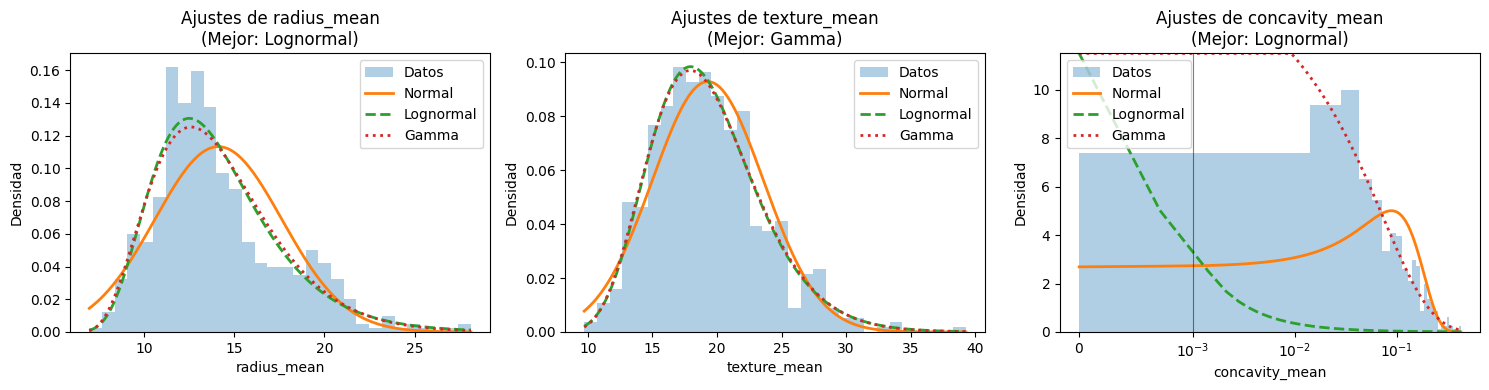

In [88]:
# Variables selecciadas
selected_features = ["radius_mean", "texture_mean", "concavity_mean"]

# Crear diccionaro para guardar estos parametros y resultados

fit_results = {}

# Ajustar distribuciones a cada variable


def safe_fit_lognorm(x):
    x = np.asarray(x)
    # 1) Intento sin fijar loc (más flexible)
    try:
        p = st.lognorm.fit(x)  # (shape, loc, scale)
        return p, lambda xx: st.lognorm.logpdf(xx, *p), lambda xx: st.lognorm.pdf(xx, *p), "free-loc"
    except Exception:
        pass
    # 2) Si hay no-positivos, aplicar offset y fijar loc=0
    eps = 1e-6
    offset = max(eps, -(x.min()) + eps) if x.min() <= 0 else 0.0
    try:
        p = st.lognorm.fit(x + offset, floc=0)  # (shape, 0, scale)
        # pdf/ll sobre x original evaluando en x+offset
        return p, \
               lambda xx: st.lognorm.logpdf(xx + offset, *p), \
               lambda xx: st.lognorm.pdf(xx + offset, *p), \
               f"offset={offset:.2e}, loc=0"
    except Exception as e:
        raise RuntimeError(f"Lognormal fit failed even with offset. {e}")

def safe_fit_gamma(x):
    x = np.asarray(x)
    # 1) Intento sin fijar loc
    try:
        p = st.gamma.fit(x)  # (shape, loc, scale)
        return p, lambda xx: st.gamma.logpdf(xx, *p), lambda xx: st.gamma.pdf(xx, *p), "free-loc"
    except Exception:
        pass
    # 2) Offset y loc=0
    eps = 1e-6
    offset = max(eps, -(x.min()) + eps) if x.min() <= 0 else 0.0
    try:
        p = st.gamma.fit(x + offset, floc=0)
        return p, \
               lambda xx: st.gamma.logpdf(xx + offset, *p), \
               lambda xx: st.gamma.pdf(xx + offset, *p), \
               f"offset={offset:.2e}, loc=0"
    except Exception as e:
        raise RuntimeError(f"Gamma fit failed even with offset. {e}")

# --- Ajuste y evaluación ---
for feature in selected_features:
    data = df[feature].dropna().values

    # Normal
    mu, sigma = st.norm.fit(data)
    ll_norm = np.sum(st.norm.logpdf(data, mu, sigma))

    # Lognormal (robusto)
    (shape_ln, loc_ln, scale_ln), llfun_ln, pfun_ln, note_ln = safe_fit_lognorm(data)
    ll_logn = np.sum(llfun_ln(data))

    # Gamma (robusto)
    (shape_g, loc_g, scale_g), llfun_g, pfun_g, note_g = safe_fit_gamma(data)
    ll_gamma = np.sum(llfun_g(data))

    # Escoger mejor por log-verosimilitud
    best = max([("Normal", ll_norm), ("Lognormal", ll_logn), ("Gamma", ll_gamma)], key=lambda x: x[1])[0]

    fit_results[feature] = {
        "Normal": {"params": (mu, sigma), "logL": ll_norm},
        "Lognormal": {"params": (shape_ln, loc_ln, scale_ln), "logL": ll_logn, "note": note_ln, "pdf": pfun_ln},
        "Gamma": {"params": (shape_g, loc_g, scale_g), "logL": ll_gamma, "note": note_g, "pdf": pfun_g},
        "Best": best
    }

# --- Reporte de parámetros ---
for f, r in fit_results.items():
    print(f"\n===== {f} =====")
    print(f"Normal:     mu={r['Normal']['params'][0]:.4f}, sigma={r['Normal']['params'][1]:.4f},  logL={r['Normal']['logL']:.1f}")
    print(f"Lognormal:  shape={r['Lognormal']['params'][0]:.4f}, loc={r['Lognormal']['params'][1]:.4f}, scale={r['Lognormal']['params'][2]:.4f},  logL={r['Lognormal']['logL']:.1f}  [{r['Lognormal']['note']}]")
    print(f"Gamma:      shape={r['Gamma']['params'][0]:.4f}, loc={r['Gamma']['params'][1]:.4f}, scale={r['Gamma']['params'][2]:.4f},  logL={r['Gamma']['logL']:.1f}  [{r['Gamma']['note']}]")
    print(f"→ Mejor ajuste: {r['Best']}")

# --- Gráficas (versión robusta para concavity_mean) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(selected_features):
    data = df[feature].dropna().values
    x = np.linspace(data.min(), data.max(), 600)

    # Histograma (densidad) y altura máxima para escalar PDFs
    n, bins, _ = axes[i].hist(data, bins=30, density=True, alpha=0.35, label="Datos")
    ymax = float(n.max()) if len(n) else 1.0
    yclip = ymax * 1.15  # margen de 15%

    # Normal
    mu, sigma = fit_results[feature]["Normal"]["params"]
    pdf_norm = st.norm.pdf(x, mu, sigma)

    # Lognormal / Gamma (ya manejan offset si se usó)
    pdf_ln = fit_results[feature]["Lognormal"]["pdf"](x)
    pdf_g  = fit_results[feature]["Gamma"]["pdf"](x)

    # ---- Recorte para evitar picos descomunales cerca de 0 ----
    pdf_norm = np.clip(pdf_norm, 0, yclip)
    pdf_ln   = np.clip(pdf_ln,   0, yclip)
    pdf_g    = np.clip(pdf_g,    0, yclip)

    # Curvas
    axes[i].plot(x, pdf_norm, label="Normal", linewidth=2)
    axes[i].plot(x, pdf_ln,   label="Lognormal", linestyle="--", linewidth=2)
    axes[i].plot(x, pdf_g,    label="Gamma", linestyle=":", linewidth=2)

    # Títulos y ejes
    axes[i].set_title(f"Ajustes de {feature}\n(Mejor: {fit_results[feature]['Best']})")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Densidad")

    # Tratamiento especial para concavity_mean (muy sesgada cerca de 0)
    if feature == "concavity_mean":
        # Escala 'symlog' en X: lineal cerca de 0 y logarítmica en el resto
        axes[i].set_xscale('symlog', linthresh=1e-3)
        # Limitar Y para no saturar el gráfico
        axes[i].set_ylim(0, yclip)
        # Guía visual de la zona lineal cercana a 0
        axes[i].axvline(1e-3, color='k', linewidth=0.8, alpha=0.5)

    axes[i].legend()

plt.tight_layout()
plt.savefig("ajustesalasvariables.png", dpi=300, bbox_inches="tight")
plt.show()


Matriz de covarianza teorica y muestral

Matriz de covarianza muestral:



,radius_mean,texture_mean,concavity_mean
radius_mean,12.418920,4.907582,0.190128
texture_mean,4.907582,18.498909,0.103692
concavity_mean,0.190128,0.103692,0.006355



Matriz de covarianza teórica (suponiendo independencia):



,radius_mean,texture_mean,concavity_mean
radius_mean,12.397094,0.000000,0.000000
texture_mean,0.000000,18.466397,0.000000
concavity_mean,0.000000,0.000000,0.006344


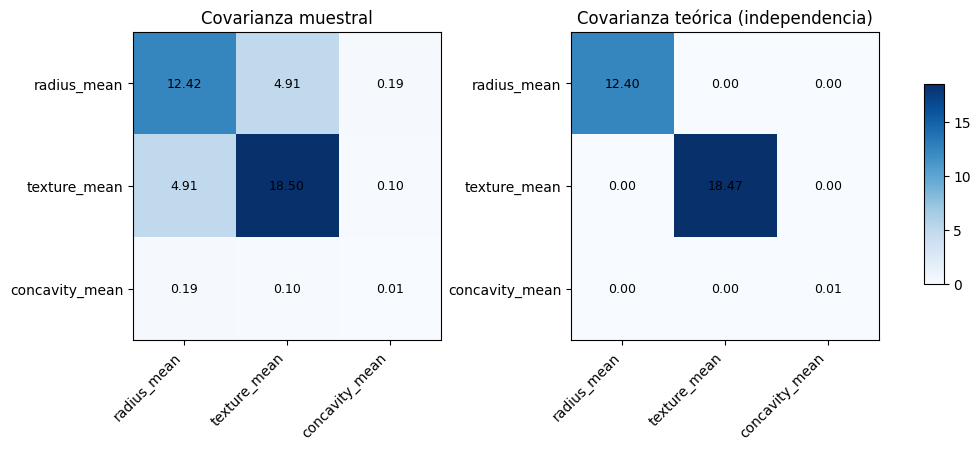

In [75]:
# Variables seleccionadas
selected_features = ["radius_mean", "texture_mean", "concavity_mean"]

# --- Covarianza muestral ---
data = df[selected_features].values
cov_muestral = np.cov(data, rowvar=False)
cov_muestral_df = pd.DataFrame(cov_muestral, index=selected_features, columns=selected_features)
print("Matriz de covarianza muestral:\n")
display(cov_muestral_df)

# --- Covarianza teórica ---
# Usaremos los parámetros ajustados (Normal) de los ajustes anteriores

vars_teoricas = [fit_results[f]["Normal"]["params"][1]**2 for f in selected_features]
cov_teorica = np.diag(vars_teoricas)
cov_teorica_df = pd.DataFrame(cov_teorica, index=selected_features, columns=selected_features)

print("\nMatriz de covarianza teórica (suponiendo independencia):\n")
display(cov_teorica_df)

# --- 4.3 Visualización comparativa (versión mejorada) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mats = [cov_muestral_df, cov_teorica_df]
titles = ["Covarianza muestral", "Covarianza teórica (independencia)"]

for ax, mat, title in zip(axes, mats, titles):
    im = ax.imshow(mat, cmap="Blues", interpolation="nearest")
    ax.set_xticks(range(len(selected_features)))
    ax.set_yticks(range(len(selected_features)))
    ax.set_xticklabels(selected_features, rotation=45, ha="right")
    ax.set_yticklabels(selected_features)
    ax.set_title(title)
    for (i, j), val in np.ndenumerate(mat):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=9)

# Agregar una sola barra de color general
cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(right=0.9, wspace=0.3)
plt.savefig("Covarianzamuestralyteorica.png", dpi=300, bbox_inches="tight")
plt.show()

Independencia y correlaciones! 

Matriz de correlación de Pearson:



,radius_mean,texture_mean,concavity_mean
radius_mean,1.000000,0.323782,0.676764
texture_mean,0.323782,1.000000,0.302418
concavity_mean,0.676764,0.302418,1.000000


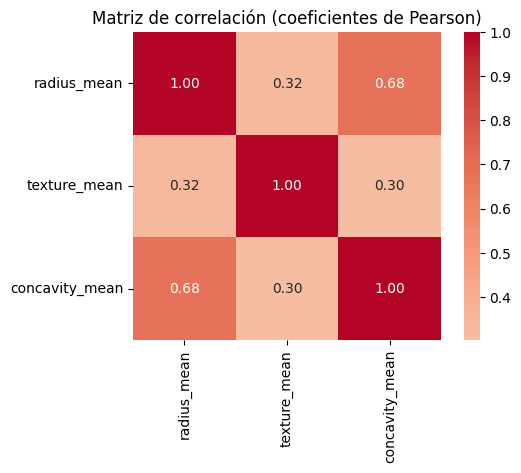


Pares con correlación |r| > 0.5 (dependencia fuerte):
  radius_mean ↔ concavity_mean  → r = 0.677


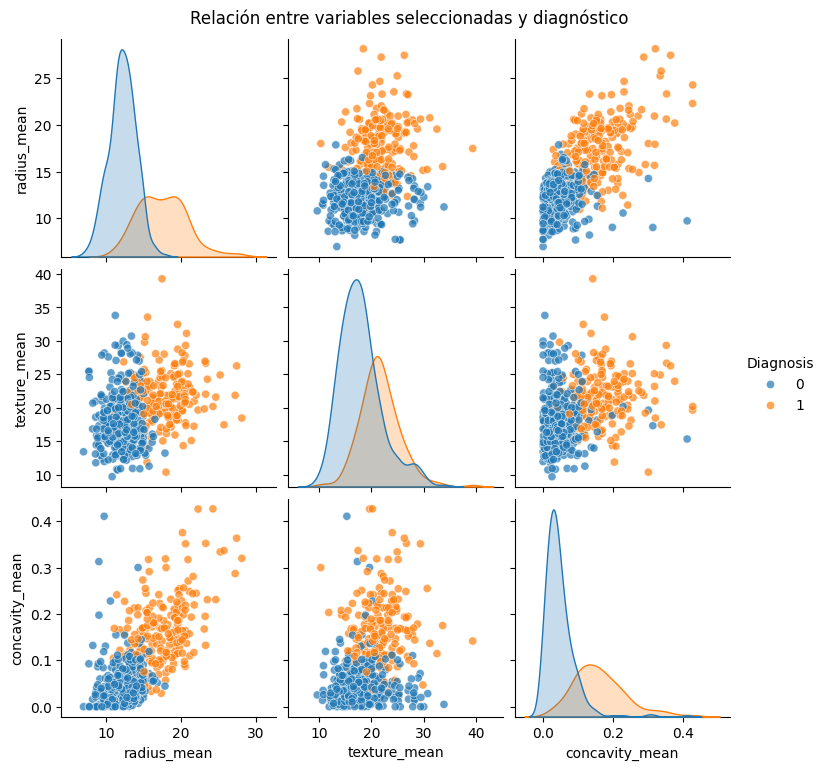

In [76]:

selected_features = ["radius_mean", "texture_mean", "concavity_mean"]

# Matriz de orrelación de Pearson

corr_matrix = df[selected_features].corr()
print("Matriz de correlación de Pearson:\n")
display(corr_matrix)

# Mapa de calor de correlación

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f")
plt.title("Matriz de correlación (coeficientes de Pearson)")
plt.savefig("Matrizdecorrelacionpearson.png", dpi=300, bbox_inches="tight")
plt.show()

# Evaluación de la independencia aproximada

threshold = 0.5
strong_corr = np.where(np.abs(corr_matrix.values) > threshold)
print("\nPares con correlación |r| > 0.5 (dependencia fuerte):")
for i, j in zip(*strong_corr):
    if i < j:
        print(f"  {selected_features[i]} ↔ {selected_features[j]}  → r = {corr_matrix.iloc[i,j]:.3f}")


# Graficas de dispersion entre las variables

sns.pairplot(df, vars=selected_features, hue="Diagnosis", diag_kind="kde",
             plot_kws={"alpha":0.7, "s":35}, diag_kws={"fill":True})
plt.suptitle("Relación entre variables seleccionadas y diagnóstico", y=1.02)
plt.savefig("Relacionentrevariablesseleccionadasydiagnostico.png", dpi=300, bbox_inches="tight")
plt.show()



Analisis de componentes principales

Varianza explicada por cada componente (%):
[63.19 26.05 10.76]

Matriz de componentes principales (cargas):


,radius_mean,texture_mean,concavity_mean
PC1,0.636866,0.443214,0.630844
PC2,-0.292460,0.895967,-0.334230
PC3,0.713351,-0.028363,-0.700233


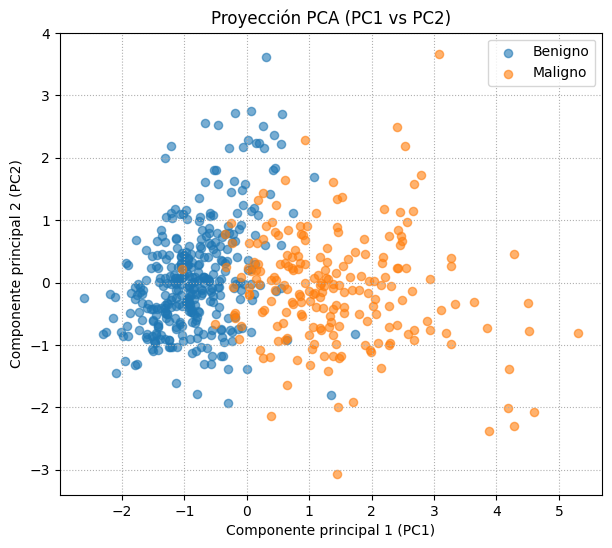

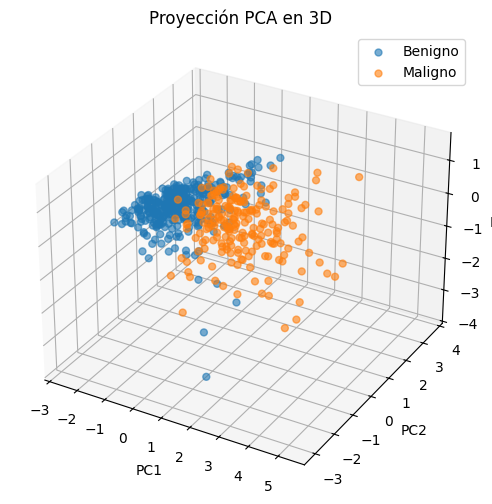

In [77]:
selected_features = ["radius_mean", "texture_mean", "concavity_mean"]

# --- 6.1 Normalización de datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[selected_features])

# --- 6.2 Aplicar PCA ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# --- 6.3 Resultados ---
explained_var = pca.explained_variance_ratio_ * 100
components = pd.DataFrame(pca.components_, columns=selected_features, index=["PC1", "PC2", "PC3"])

print("Varianza explicada por cada componente (%):")
print(explained_var.round(2))
print("\nMatriz de componentes principales (cargas):")
display(components)

# --- 6.4 Visualización 2D (PC1 vs PC2) ---
plt.figure(figsize=(7, 6))
plt.scatter(X_pca[df["Diagnosis"] == 0, 0], X_pca[df["Diagnosis"] == 0, 1], 
            alpha=0.6, label="Benigno", s=35)
plt.scatter(X_pca[df["Diagnosis"] == 1, 0], X_pca[df["Diagnosis"] == 1, 1], 
            alpha=0.6, label="Maligno", s=35)
plt.xlabel("Componente principal 1 (PC1)")
plt.ylabel("Componente principal 2 (PC2)")
plt.title("Proyección PCA (PC1 vs PC2)")
plt.legend()
plt.grid(True, linestyle=":")
plt.savefig("proyeccion pca 2d.png", dpi=300, bbox_inches="tight")
plt.show()

# --- 6.5 Visualización 3D ---
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[df["Diagnosis"] == 0, 0], X_pca[df["Diagnosis"] == 0, 1], X_pca[df["Diagnosis"] == 0, 2],
           alpha=0.6, label="Benigno", s=25)
ax.scatter(X_pca[df["Diagnosis"] == 1, 0], X_pca[df["Diagnosis"] == 1, 1], X_pca[df["Diagnosis"] == 1, 2],
           alpha=0.6, label="Maligno", s=25)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Proyección PCA en 3D")
ax.legend()
plt.savefig("proyeccionpca3d", dpi=300, bbox_inches="tight")
plt.show()

Decorrelacion y Whitening   

In [78]:
# Calcular la matriz de covarianza de los datos originales

X_original = df[["radius_mean", "texture_mean", "concavity_mean"]].values
cov_original = np.cov(X_original, rowvar=False)

print("Matriz de covarianza original:\n")
display(pd.DataFrame(cov_original, 
                     index=["radius_mean", "texture_mean", "concavity_mean"], 
                     columns=["radius_mean", "texture_mean", "concavity_mean"]))


Matriz de covarianza original:



,radius_mean,texture_mean,concavity_mean
radius_mean,12.418920,4.907582,0.190128
texture_mean,4.907582,18.498909,0.103692
concavity_mean,0.190128,0.103692,0.006355


In [79]:
# Covarianza de los componentes principales

cov_pca = np.cov(X_pca, rowvar=False)
print("\nMatriz de covarianza tras PCA (esperamos ≈ diagonal):\n")
display(pd.DataFrame(cov_pca, 
                     index=["PC1", "PC2", "PC3"], 
                     columns=["PC1", "PC2", "PC3"]))



Matriz de covarianza tras PCA (esperamos ≈ diagonal):



,PC1,PC2,PC3
PC1,1.899032e+00,-1.665335e-16,-9.069428e-17
PC2,-1.665335e-16,7.828740e-01,1.970255e-16
PC3,-9.069428e-17,1.970255e-16,3.233761e-01


In [80]:
# Para el whitening, escalo la raiz de la varianza de cada componente

X_whitened = X_pca / np.sqrt(pca.explained_variance_)
cov_whitened = np.cov(X_whitened, rowvar=False)

print("\nMatriz de covarianza tras Whitening (esperamos ≈ identidad):\n")
display(pd.DataFrame(cov_whitened, 
                     index=["PC1", "PC2", "PC3"], 
                     columns=["PC1", "PC2", "PC3"]))


Matriz de covarianza tras Whitening (esperamos ≈ identidad):



,PC1,PC2,PC3
PC1,1.000000e+00,-9.401713e-17,-1.422962e-16
PC2,-9.401713e-17,1.000000e+00,3.690319e-16
PC3,-1.422962e-16,3.690319e-16,1.000000e+00


Visualizacion decorelacion y whitening

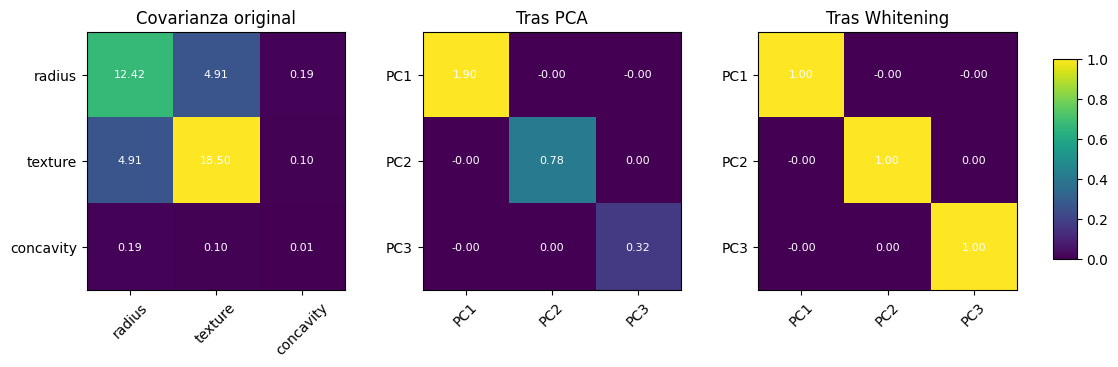

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
mats = [cov_original, cov_pca, cov_whitened]
titles = ["Covarianza original", "Tras PCA", "Tras Whitening"]

for ax, mat, title in zip(axes, mats, titles):
    im = ax.imshow(mat, cmap="viridis", interpolation="nearest")
    ax.set_title(title)
    for (i, j), val in np.ndenumerate(mat):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="white", fontsize=8)
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    if title == "Covarianza original":
        labels = ["radius", "texture", "concavity"]
    else:
        labels = ["PC1", "PC2", "PC3"]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

# Agregar una sola barra de color
cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(right=0.9, wspace=0.3)
plt.savefig("matricescovarianzaoriginalpcawhitening.png", dpi=300, bbox_inches="tight")
plt.show()

Clasificador Bayesiano (QDA)

In [82]:
# dividir los datos para entrenar y prueba

X = df[["radius_mean", "texture_mean", "concavity_mean"]].values
y = df["Diagnosis"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Entrenar el clasificador bayesiano

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Predigo 

y_pred = qda.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Exactitud del clasificador QDA: {acc*100:.2f}%")
print("\nMatriz de confusión:")
print(cm)



Exactitud del clasificador QDA: 92.40%

Matriz de confusión:
[[106   1]
 [ 12  52]]


Visualizacion de fronteras de decision 

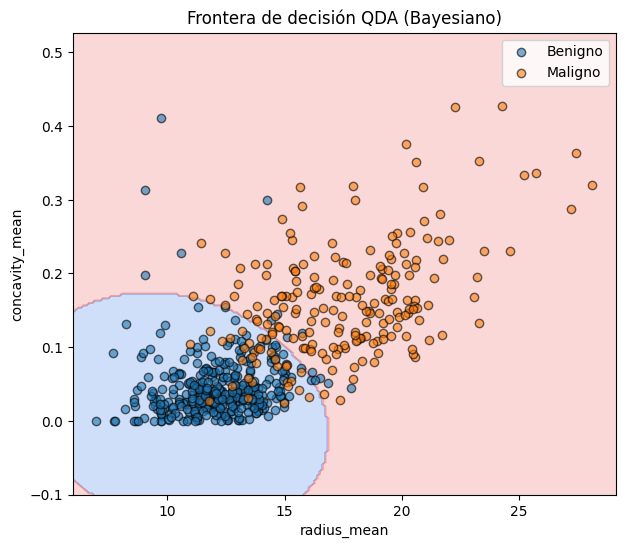

In [83]:
from matplotlib.colors import ListedColormap

f1, f2 = "radius_mean", "concavity_mean"
X_plot = df[[f1, f2]].values
y_plot = df["Diagnosis"].values

qda_plot = QuadraticDiscriminantAnalysis().fit(X_plot, y_plot)

x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 0.1, X_plot[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = qda_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(["cornflowerblue", "lightcoral"]))
plt.scatter(X_plot[y_plot==0, 0], X_plot[y_plot==0, 1], label="Benigno", edgecolor='k', alpha=0.6)
plt.scatter(X_plot[y_plot==1, 0], X_plot[y_plot==1, 1], label="Maligno", edgecolor='k', alpha=0.6)
plt.xlabel(f1)
plt.ylabel(f2)
plt.title("Frontera de decisión QDA (Bayesiano)")
plt.legend()
plt.savefig("fronteradedecisionqda.png", dpi=300, bbox_inches="tight")
plt.show()

Probabilidad de error teorico vs empirico

In [84]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Definir features y split 
features = ["radius_mean", "texture_mean", "concavity_mean"]
X = df[features].values
y = df["Diagnosis"].values  # 1=maligno, 0=benigno

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Entrenar QDA (Bayes plugin)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)

#  Error empírico en test
y_pred = qda.predict(X_test)
acc_emp = accuracy_score(y_test, y_pred)
cm_emp = confusion_matrix(y_test, y_pred)
err_emp = 1 - acc_emp

print("=== Error empírico (test) ===")
print(f"Exactitud: {acc_emp*100:.2f}%  |  Error: {err_emp*100:.2f}%")
print("Matriz de confusión (test):")
print(cm_emp)

# Estimación "teórica" (Monte Carlo) bajo gaussianas clase-condicionales
# Priori por frecuencia en entrenamiento
pi0 = np.mean(y_train == 0)
pi1 = 1 - pi0

# Medias y covarianzas por clase del QDA entrenado
mu0, mu1 = qda.means_[0], qda.means_[1]
Sigma0, Sigma1 = qda.covariance_[0], qda.covariance_[1]

rng = np.random.default_rng(123)
Nsim = 200_000  # por clase (ajusta si quieres más precisión)

# Muestras simuladas por clase
X0 = rng.multivariate_normal(mu0, Sigma0, size=Nsim)
X1 = rng.multivariate_normal(mu1, Sigma1, size=Nsim)

# Decisión bayesiana: usar el modelo QDA ya entrenado para predecir
y0_pred = qda.predict(X0)   # deberían ser 0 si no hay error
y1_pred = qda.predict(X1)   # deberían ser 1 si no hay error

# Tasa de error condicional por clase
Pe0 = np.mean(y0_pred != 0)  # P(error | clase=0)
Pe1 = np.mean(y1_pred != 1)  # P(error | clase=1)

# Error total (promedio ponderado por priors)
Pe_total = pi0 * Pe0 + pi1 * Pe1

print("\n=== Estimación 'teórica' del error (Monte Carlo bajo gaussianas) ===")
print(f"P(error | clase=0, benigno): {Pe0*100:.2f}%")
print(f"P(error | clase=1, maligno): {Pe1*100:.2f}%")
print(f"Error Bayes (ponderado por priors): {Pe_total*100:.2f}%")

#  Resumen en una tablita
res = pd.DataFrame({
    "Métrica": ["Exactitud Empírica (test)", "Error Empírico (test)", 
                "P(error|Benigno)", "P(error|Maligno)", "Error Bayes ponderado"],
    "Valor": [acc_emp, err_emp, Pe0, Pe1, Pe_total]
})
display(res)

# (Opcional) Guardar la tabla
res.to_csv("resumen_error_bayes_vs_empirico.csv", index=False)
print("\nArchivo guardado: resumen_error_bayes_vs_empirico.csv")

=== Error empírico (test) ===
Exactitud: 92.40%  |  Error: 7.60%
Matriz de confusión (test):
[[106   1]
 [ 12  52]]

=== Estimación 'teórica' del error (Monte Carlo bajo gaussianas) ===
P(error | clase=0, benigno): 3.37%
P(error | clase=1, maligno): 16.07%
Error Bayes (ponderado por priors): 8.09%


,Métrica,Valor
0,Exactitud Empírica (test),0.923977
1,Error Empírico (test),0.076023
2,P(error|Benigno),0.033700
3,P(error|Maligno),0.160690
4,Error Bayes ponderado,0.080922



Archivo guardado: resumen_error_bayes_vs_empirico.csv


Visualizacion!

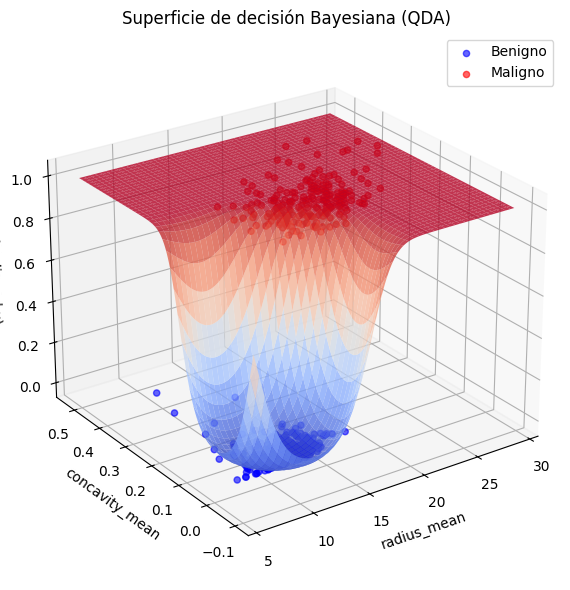

In [85]:
# Variables que usaremos para visualizar (las mismas del análisis anterior)
f1, f2 = "radius_mean", "concavity_mean"
X_2d = df[[f1, f2]].values
y_2d = df["Diagnosis"].values

# Entrenamos el QDA nuevamente
qda_2d = QuadraticDiscriminantAnalysis()
qda_2d.fit(X_2d, y_2d)

# Malla de puntos para cubrir el espacio
x_min, x_max = X_2d[:,0].min()-1, X_2d[:,0].max()+1
y_min, y_max = X_2d[:,1].min()-0.1, X_2d[:,1].max()+0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Calculamos la probabilidad posterior de la clase maligna (1)
Z = qda_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)

# --- Figura 3D ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Superficie de probabilidad
ax.plot_surface(xx, yy, Z, cmap="coolwarm", alpha=0.8, linewidth=0, antialiased=True)

# Añadimos los puntos de datos originales
ax.scatter(X_2d[y_2d==0,0], X_2d[y_2d==0,1], 0, c='blue', label="Benigno", alpha=0.6)
ax.scatter(X_2d[y_2d==1,0], X_2d[y_2d==1,1], 1, c='red', label="Maligno", alpha=0.6)

# Etiquetas y título
ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel("P(Maligno | x)")
ax.set_title("Superficie de decisión Bayesiana (QDA)")

ax.view_init(elev=25, azim=235)
ax.legend()
plt.tight_layout()
plt.savefig("superficie_decision_qda_3d.png", dpi=300)
plt.show()

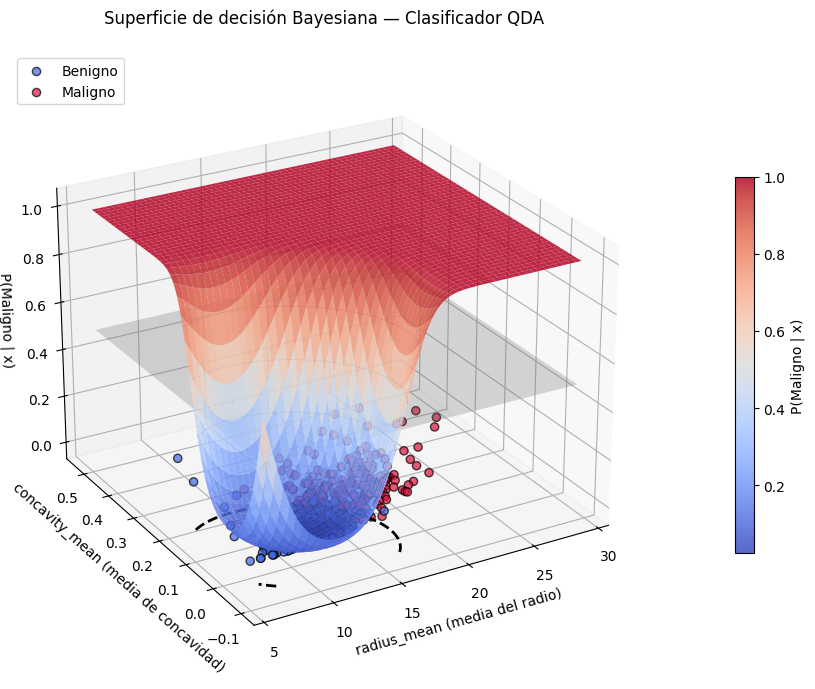

In [86]:
# Variables seleccionadas
f1, f2 = "radius_mean", "concavity_mean"
X_2d = df[[f1, f2]].values
y_2d = df["Diagnosis"].values

# Entrenamiento del clasificador QDA
qda_2d = QuadraticDiscriminantAnalysis()
qda_2d.fit(X_2d, y_2d)

# --- Malla ---
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 0.1, X_2d[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                     np.linspace(y_min, y_max, 250))

# Probabilidad posterior de clase maligna
Z = qda_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

# --- Figura ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Superficie de probabilidad
surf = ax.plot_surface(xx, yy, Z, cmap="coolwarm", alpha=0.85, linewidth=0, antialiased=True)

# Plano de decisión P=0.5
ax.plot_surface(xx, yy, np.full_like(Z, 0.5), color="gray", alpha=0.25)

# Curva de nivel P=0.5 en el plano XY (base)
ax.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=2, linestyles="--", offset=0)

# Curvas de nivel adicionales sobre la superficie
ax.contour(xx, yy, Z, zdir='z', levels=np.linspace(0,1,6), offset=None, colors="k", alpha=0.3, linewidths=0.7)

# Puntos reales
ax.scatter(X_2d[y_2d==0, 0], X_2d[y_2d==0, 1], 0, c='royalblue', edgecolor='k', label="Benigno", alpha=0.7, s=35)
ax.scatter(X_2d[y_2d==1, 0], X_2d[y_2d==1, 1], 0, c='crimson', edgecolor='k', label="Maligno", alpha=0.7, s=35)

# Etiquetas
ax.set_xlabel(f"{f1} (media del radio)")
ax.set_ylabel(f"{f2} (media de concavidad)")
ax.set_zlabel("P(Maligno | x)")
ax.set_title("Superficie de decisión Bayesiana — Clasificador QDA", pad=20)

# Vista y estética
ax.view_init(elev=25, azim=240)
ax.legend(loc="upper left")
fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label="P(Maligno | x)")
plt.tight_layout()

# Guardar figura
plt.savefig("superficie_decision_qda_3d_academica_contornos.png", dpi=300, bbox_inches="tight")
plt.show()

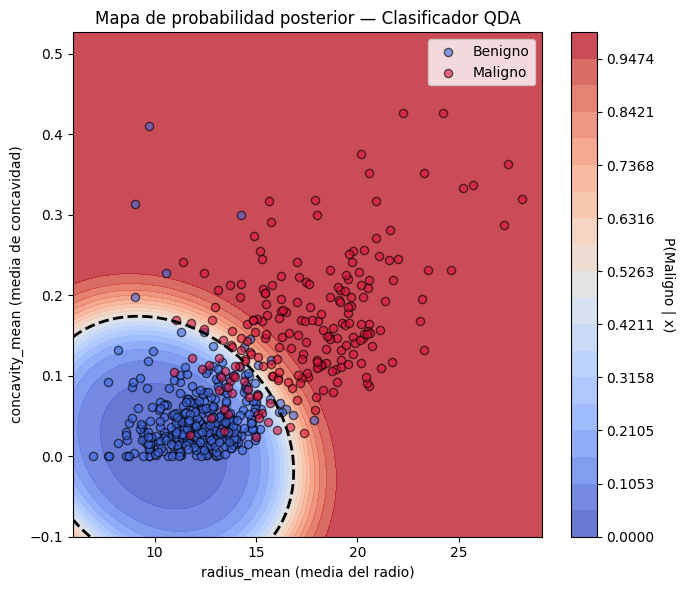

In [87]:
f1, f2 = "radius_mean", "concavity_mean"
X_2d = df[[f1, f2]].values
y_2d = df["Diagnosis"].values

# Entrenar QDA
qda_2d = QuadraticDiscriminantAnalysis()
qda_2d.fit(X_2d, y_2d)

# Crear malla
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 0.1, X_2d[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Probabilidad posterior de clase maligna
Z = qda_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

# --- Figura 2D académica ---
plt.figure(figsize=(7,6))
cont = plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 20), cmap="coolwarm", alpha=0.8)
cbar = plt.colorbar(cont)
cbar.set_label("P(Maligno | x)", rotation=270, labelpad=15)

# Frontera de decisión P=0.5
plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2, linestyles="--")

# Puntos reales
plt.scatter(X_2d[y_2d==0, 0], X_2d[y_2d==0, 1], c="royalblue", edgecolor="k", label="Benigno", alpha=0.6, s=35)
plt.scatter(X_2d[y_2d==1, 0], X_2d[y_2d==1, 1], c="crimson", edgecolor="k", label="Maligno", alpha=0.6, s=35)

# Etiquetas
plt.xlabel(f"{f1} (media del radio)")
plt.ylabel(f"{f2} (media de concavidad)")
plt.title("Mapa de probabilidad posterior — Clasificador QDA")
plt.legend()
plt.tight_layout()
plt.savefig("superficie_decision_qda_2d_academica.png", dpi=300, bbox_inches="tight")
plt.show()